In [8]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
import yaml

import matplotlib.pyplot as plt

from assistive_arm.utils.plotting import extract_muscle_activations, plot_res_assist_forces, plot_residual_forces

### Setup paths

In [9]:
solutions_path = Path("../moco/control_solutions/")
subject = "subject_4"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject testing/Subject data/") / subject
trial = subject_data / "trial_4"

# solution_assist_false = solutions_path / "opencap_simple_assistance_false_2023-09-22_17-13.sto"
solution_assist_false = solutions_path / "subject_4_simple_trial_3_assistance_none_2023-11-15_14-59.sto"
solution_assist_true = solutions_path / "subject_4_simple_trial_4_assistance_true_2023-10-11_08-20.sto"
grfs = trial / "grf_filtered.mot"

### Read control solutions and config file

In [10]:
df_assist_false = pd.read_csv(solution_assist_false, delimiter="\t", skiprows=18)
df_assist_true = pd.read_csv(solution_assist_true, delimiter="\t", skiprows=18)
ground_forces = pd.read_csv(grfs, delimiter="\t", skiprows=6)

config_path = solutions_path / f"{solution_assist_false.stem}.yaml"
with open(config_path, "r") as f:
    config_file = yaml.load(f, Loader=yaml.FullLoader)
print(yaml.dump(config_file, indent=4, sort_keys=False))

actuator_magnitude: 700
assistive_force: null
grf_path: /Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject
    testing/Subject data/subject_4/trial_3/grf_filtered.mot
ground_forces: true
mesh_interval: 0.05
minimal_actuators: false
reserve_pelvis_weight: 15
solution_name: subject_4_simple_trial_3_assistance_none_2023-11-15_14-59
solution_path: ./moco/control_solutions/subject_4_simple_trial_3_assistance_none_2023-11-15_14-59.sto
subject: subject_4
t_0: 5.7
t_f: 7.25
target_path: /Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject
    testing/Subject data/subject_4/model
trial: /Users/xabieririzar/Desktop/Life/Studium/TUM/M.Sc Robotics/Harvard/Thesis/Subject
    testing/Subject data/subject_4/trial_3
xml_path: ./moco/models/subject_4_simple_LaiUhlrich2022_scaled.osim



In [11]:
def plot_residual_forces(df: pd.DataFrame, config_file: dict):
    tx = 'reserve_pelvis_tx' if config_file["minimal_actuators"] else '/forceset/reserve_jointset_ground_pelvis_pelvis_tx'
    ty = 'reserve_pelvis_ty' if config_file["minimal_actuators"] else '/forceset/reserve_jointset_ground_pelvis_pelvis_ty'
    tz = 'reserve_pelvis_tz' if config_file["minimal_actuators"] else '/forceset/reserve_jointset_ground_pelvis_pelvis_tz'

    plt.plot(df.time, df[tx]*config_file["actuator_magnitude"], label=f'Residual X')
    plt.plot(df.time, df[ty]*config_file["actuator_magnitude"], label=f'Residual Y')
    plt.plot(df.time, df[tz]*config_file["actuator_magnitude"], label=f'Residual Z')
    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.title(f"Residual forces ({'assisted' if config_file['assistive_force'] else 'unassisted'})")
    plt.legend()
    plt.show()

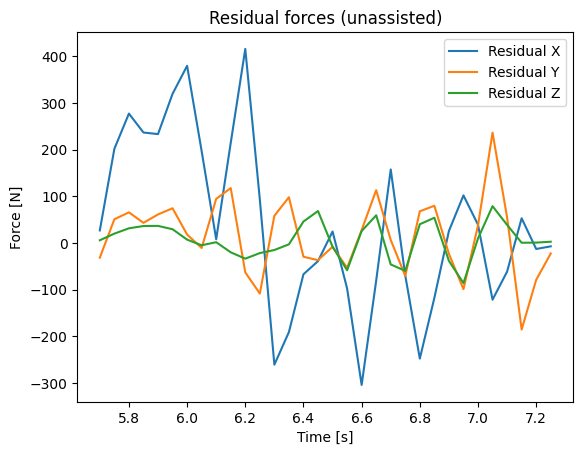

In [12]:
plot_residual_forces(df=df_assist_false, config_file=config_file)

In [13]:
ground_forces = ground_forces[(ground_forces["time"] >= config_file["t_0"]) & (ground_forces["time"] <= config_file["t_f"])]

dfs = {}
# dfs["assist_false"] = df_assist_false
dfs["assist_true"] = df_assist_true
dfs["ground_forces"] = ground_forces

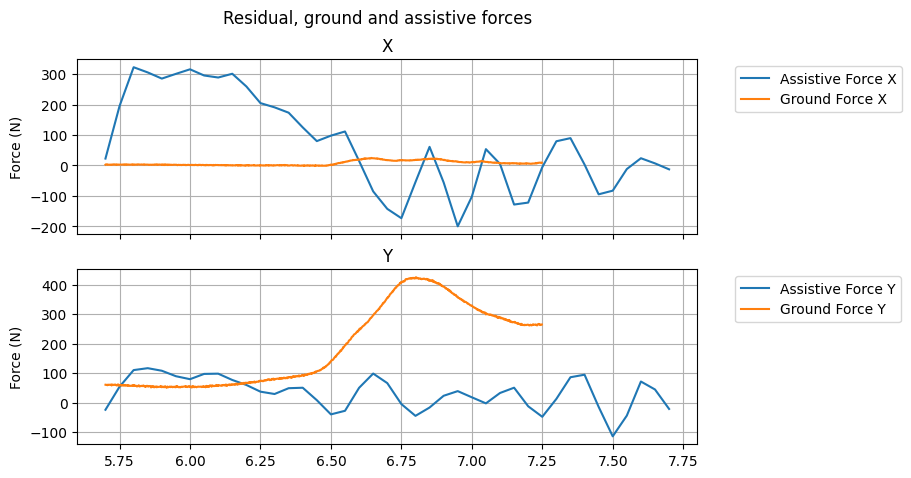

In [14]:
plot_res_assist_forces(time=df_assist_true.time, dataframes=dfs, figsize=(8,5), config=config_file)

### Plot residual forces

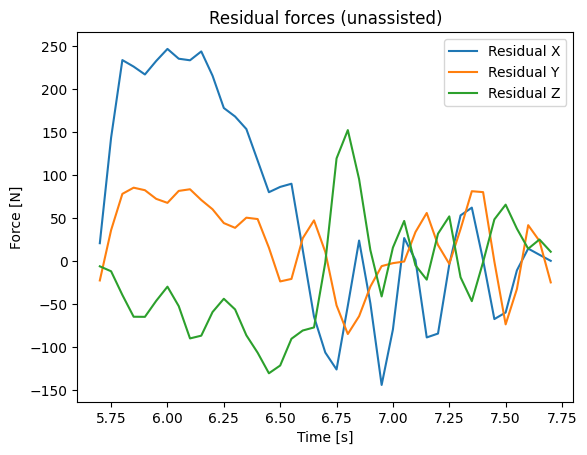

In [15]:
plot_residual_forces(df_assist_true, config_file=config_file)

In [16]:
simple_df_false_activations = extract_muscle_activations(df_assist_false, apply_filter=False)
simple_df_true_reduced_activations = extract_muscle_activations(df_assist_true, apply_filter=False)[simple_df_false_activations.columns]

# Only look at recfem and vasmed
simple_df_false_activations = simple_df_false_activations[["recfem_r", "vasmed_r", "recfem_l", "vasmed_l", "soleus_r", "soleus_l", "tibant_r", "tibant_l"]]
simple_df_true_reduced_activations = simple_df_true_reduced_activations[["recfem_r", "vasmed_r", "recfem_l", "vasmed_l", "soleus_r", "soleus_l", "tibant_r", "tibant_l"]]

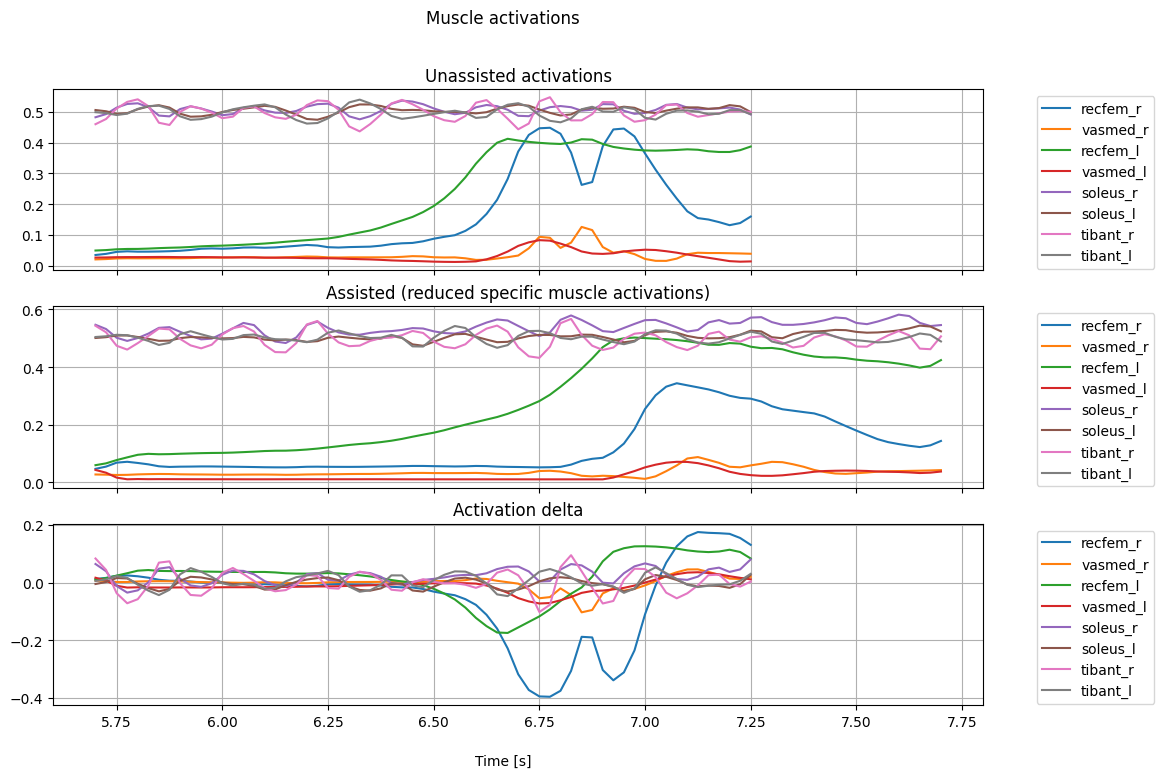

In [17]:
fig, axs = plt.subplots(3, figsize=(12, 8), sharex=True)

fig.suptitle("Muscle activations")

# Activations with no assistance
axs[0].plot(df_assist_false.time, simple_df_false_activations, label=simple_df_false_activations.columns)
axs[0].set_title('Unassisted activations')
axs[0].grid()
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axs[1].plot(df_assist_true.time, simple_df_true_reduced_activations, label=simple_df_true_reduced_activations.columns)
axs[1].set_title('Assisted (reduced specific muscle activations)')
axs[1].grid()
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

axs[2].plot(df_assist_true.time, simple_df_true_reduced_activations - simple_df_false_activations, label=simple_df_true_reduced_activations.columns)
axs[2].set_title('Activation delta')
axs[2].grid()
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Define xlabel
fig.text(0.5, 0.04, 'Time [s]', ha='center', va='center')

# plt.tight_layout()
plt.show()